## Part 2. - Fit Scalar Targets
We examine details of the fitting process...
 - examine the role of scaling
 - examine y_range **TODO**
 - examine each task for difficulty by a comparison to baseline performance.
 - compare NN's against Linear Regression

In [1]:
import os, sys
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt

from fastai2.basics import *
from fastai2.vision.all import *

from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2

from module.mnist_helpers import build_df, eda_fig_1

### Setup UnScaled vs. Scaled target arrays

In [2]:
path = untar_data(URLs.MNIST_TINY)

df = build_df(path)
df.head(2)

target_names = [   
        'scalar_pxsum',
        'scalar_top',
        'scalar_bottom',
       ]

db_reg_multi =   DataBlock(blocks=(ImageBlock(cls=PILImageBW), 
                                   RegressionBlock(n_out=3)), 
                       splitter=RandomSplitter(seed=0),
                       get_x=ColReader('fn', pref=path),
                       get_y=ColReader(target_names)
                      )

dls_reg_multi = db_reg_multi.dataloaders(df)

In [3]:
target_names_sc = [name + '_sc' for name in target_names]

sc = StandardScaler()
sc.fit(df[target_names])

df_sc = pd.DataFrame(sc.transform(df[target_names])
                     ,columns=target_names_sc)

df = pd.concat((df, df_sc), axis=1)

db_reg_multi_sc =   DataBlock(blocks=(ImageBlock(cls=PILImageBW), 
                                     RegressionBlock(n_out=3)), 
                       splitter=RandomSplitter(seed=0),
                       get_x=ColReader('fn', pref=path),
                       get_y=ColReader(target_names_sc)
                      )

dls_reg_multi_sc = db_reg_multi_sc.dataloaders(df)

##### Note: verify the same train/valid split

In [4]:
[len(split) for split in dls_reg_multi.train.splits]

[568, 141]

In [5]:
dls_reg_multi.splits[0] == dls_reg_multi_sc.splits[0]

True

### EDA - For each target: mean estimate, baseline err 

In [6]:
y = torch.stack([_y for _x, _y in dls_reg_multi.train])
y = y.flatten(0,1)

mean_y_uc = y.mean(dim=0)

y = torch.cat([_y for _x, _y in dls_reg_multi.valid])

mse_uc = [mse(y[:,i], torch.full( (len(y),), mean_y_uc[i])) 
          for i in range(3)]

mse_uc

[tensor(47956224.), tensor(1.7019), tensor(1.7546)]

In [7]:
y = torch.stack([_y for _x, _y in dls_reg_multi_sc.train])
y = y.flatten(0,1)

mean_y_sc = y.mean(dim=0)

y = torch.cat([_y for _x, _y in dls_reg_multi_sc.valid])

mse_sc = [mse(y[:,i], torch.full( (len(y),), mean_y_sc[i])) 
          for i in range(3)]

mse_sc

[tensor(0.8454), tensor(0.9894), tensor(0.9676)]

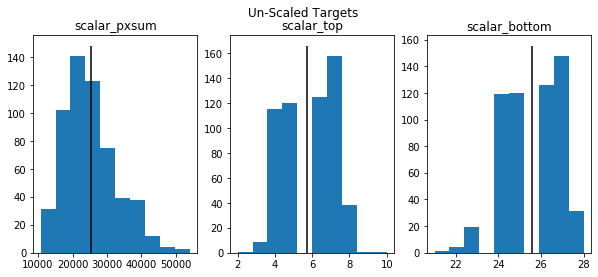

In [8]:
ys = tensor([e[1].tolist() for e in dls_reg_multi.dataset])

fig, ax = plt.subplots(1,3,figsize=(10,3+1))
for i in range(3):
    vals = ys[:,i]
    ax[i].hist(vals)
    ax[i].set_title(target_names[i])
    ax[i].vlines(mean_y_uc[i],*ax[i].get_ylim())
    
fig.suptitle('Un-Scaled Targets');

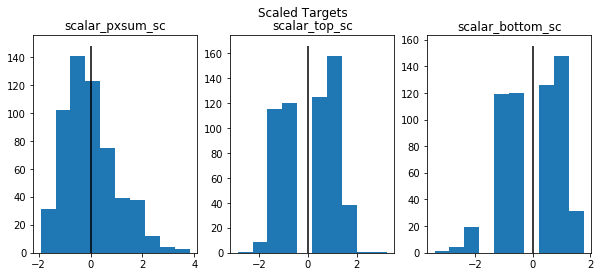

In [9]:
ys = tensor([e[1].tolist() for e in dls_reg_multi_sc.dataset])

fig, ax = plt.subplots(1,3,figsize=(10,3+1))
for i in range(3):
    vals = ys[:,i]
    ax[i].hist(vals)
    ax[i].set_title(target_names_sc[i])
    ax[i].vlines(mean_y_sc[i],*ax[i].get_ylim())
    
fig.suptitle('Scaled Targets');

### Fit the unscaled version - bad!
Here well see that error is hard to interpret because:
 - the values are so large - 1e8 - they are hard to eyeball
 - the errors aren't consistent across targets so larger values scalars will be weighted mroe heavily. (Fastai present the mse metric in the tabular outputs below as the mean of the mse's of each respective target scalar.)
 
And we'll see that we fail to beat baseline/mean-prediction on the large value scalar because the output layer values can't reach the required scale within a normal number of training epochs.

In [15]:
b_new_fit = True

cbs = CSVLogger('rm_1.csv') if b_new_fit else None

learn_reg_multi = cnn_learner(dls_reg_multi, 
                              resnet18, 
                              pretrained=True,
                              cbs = cbs
                             )
# load existing model
if not(b_new_fit):
    fn = 'reg_multi_50'
    learn_reg_multi.load(fn)
    
# fit and save model
if b_new_fit:

    with learn_reg_multi.no_logging():
        learn_reg_multi.fit(50)

    fn = 'reg_multi_50'
    learn_reg_multi.save(fn)
    print(f'{fn} saved to {learn_reg_multi.path}/models/')

reg_multi_50 saved to ./models/


In [16]:
train_history = pd.read_csv('rm_1.csv')

In [19]:
display(train_history.head(2))
display(train_history.tail(2))

,epoch,train_loss,valid_loss,time
0,0,229732240.0,225022800.0,00:05
1,1,231235632.0,225052688.0,00:05


,epoch,train_loss,valid_loss,time
48,48,229766192.0,222098208.0,00:05
49,49,229733904.0,221991888.0,00:05


##### Notice: this unscaled model fits poorly
 1. error does reduce but does so only slowly
 
 2. the model error is still well above the baseline error even after 50 epochs of training.

In [27]:
sum(mse_uc)/len(mse_uc)

tensor(15985408.)

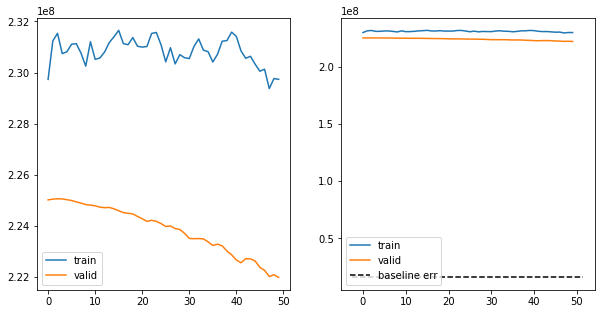

In [30]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(train_history['train_loss'])
ax[0].plot(train_history['valid_loss']);
ax[0].legend(['train','valid']);
ax[1].plot(train_history['train_loss'])
ax[1].plot(train_history['valid_loss']);
baseline_err = sum(mse_uc)/len(mse_uc)
ax[1].hlines(baseline_err, *ax[1].get_xlim(), linestyle='--')
ax[1].legend(['train','valid', 'baseline err']);

In [104]:
preds = learn_reg_multi.get_preds(with_loss=True)

##### Notice: the model for PxSum captures the relationship but not the scale
While with ScalarBottom, there isn't a good relationship captured but our error isn't so high from that due to it being on roughly the same scale.

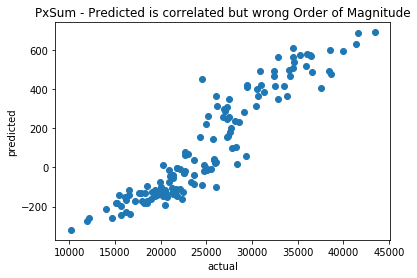

In [105]:
plt.scatter( preds[1][:,0].tolist(), preds[0][:,0].tolist())
plt.xlabel('actual')
plt.ylabel('predicted');
plt.title('PxSum - Predicted is correlated but wrong Order of Magnitude');

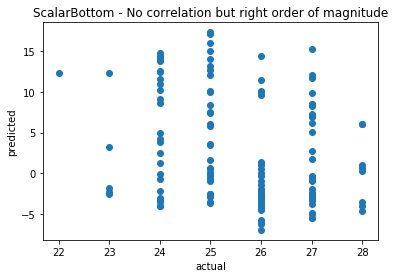

In [110]:
plt.scatter( preds[1][:,2].tolist(), preds[0][:,2].tolist())
plt.xlabel('actual')
plt.ylabel('predicted');
plt.title('ScalarBottom - No correlation but right order of magnitude');

##### Note, each gradient update cycle only updates output layer slightly
This is due to low learning rate. 

Therefore it becomes difficult to ever have yhat_bar -approach-> yactual_bar for large value scalars.

### Fit Scaled Version - good!
This will allow us to overcome the slow updating and do an apples-tapples comparison on each target's difficulty.

Breakout mse by component.

In [31]:
learn_reg_multi_sc = cnn_learner(dls_reg_multi_sc, 
                              resnet18, 
                              pretrained=True,
                              cbs = CSVLogger('rm_1_sc.csv')
                             )

In [32]:
fn = 'reg_multi_sc_50'
learn_reg_multi.load(fn)

In [155]:
with learn_reg_multi_sc.no_logging():
    learn_reg_multi_sc.fit(50)

In [157]:
fn = 'reg_multi_sc_50'
learn_reg_multi.save(fn)
print(f'{fn} saved to {learn_reg_multi.path}/models/')

reg_multi_sc_50 saved to ./models/


In [159]:
train_history = pd.read_csv('rm_1_sc.csv')
train_history.to_csv('rm_1_sc_saved.csv')
display(train_history.head(2))
display(train_history.tail(2))

,epoch,train_loss,valid_loss,time
0,0,4.694417,0.850316,00:05
1,1,4.279676,1.013585,00:04


,epoch,train_loss,valid_loss,time
48,48,0.305155,0.348429,00:04
49,49,0.294492,0.353889,00:05


##### Replicate error calculations per row

In [160]:
preds = learn_reg_multi_sc.get_preds(with_loss=True)

In [161]:
preds[0][0]   # predicted, row0

tensor([ 0.8932, -0.5297, -0.3104])

In [162]:
preds[1][0]   # actual, row0

tensor([ 1.4377, -1.3478, -1.1921])

In [163]:
mse(preds[0][0][0], preds[1][0][0])  # mse on target0, row0

tensor(0.2964)

In [164]:
# mean mse on all targets in row0
torch.stack([mse(preds[0][0][i], preds[1][0][i])
             for i in range(3)]).mean()   

tensor(0.5810)

In [165]:
# matches, err output for row0 from get_preds()
preds[2][0]

tensor(0.5810)

##### Examine Training History
Good it drops below baseline quickly and looks like we stopped just before overfitting.

In [194]:
# need this because for some reason the 
# csv keeps getting overwritten

# new_df = tmp.iloc[:,1:]
# new_df.to_csv(fn, index=False)

fn = 'rm_1_sc_saved.csv'
tmp = pd.read_csv(fn)
tmp.to_csv(fn, index=False)
train_history_sc = tmp.copy()

,epoch,train_loss,valid_loss,time
0,0,4.694417,0.850316,00:05
1,1,4.279676,1.013585,00:04


,epoch,train_loss,valid_loss,time
48,48,0.305155,0.348429,00:04
49,49,0.294492,0.353889,00:05


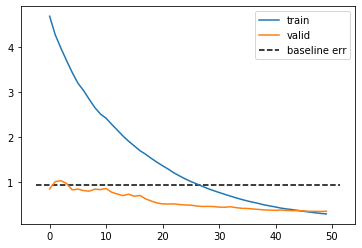

In [197]:
# train_history_sc = pd.read_csv('rm_1_sc.csv')
baseline_err = tensor(mse_sc).mean().tolist()

display(train_history_sc.head(2))
display(train_history_sc.tail(2))

plt.plot(train_history_sc['train_loss'])
plt.plot(train_history_sc['valid_loss']);

plt.hlines(baseline_err, *plt.xlim(), linestyles='--')
plt.legend(['train','valid', 'baseline err']);

##### Examine Training Accuracy

In [198]:
preds = learn_reg_multi_sc.get_preds(with_loss=True)

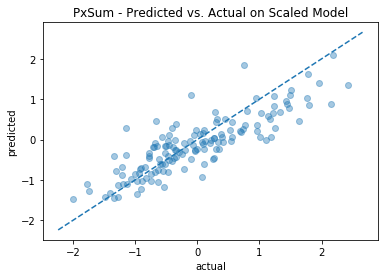

In [199]:
plt.scatter( preds[1][:,0], preds[0][:,0], alpha=0.4)
plt.xlabel('actual')
plt.ylabel('predicted');
xlo, xhi = plt.xlim()
ylo, yhi = plt.ylim()
lo, hi = min(xlo,ylo), max(xhi,yhi)
plt.plot([lo,hi], [lo,hi], linestyle='--');
plt.title('PxSum - Predicted vs. Actual on Scaled Model');

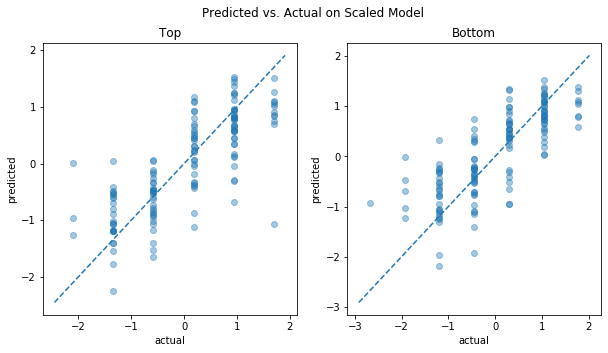

In [205]:
fig, ax  = plt.subplots(1,2,figsize=(10,5))
for i, (ind, name) in enumerate([(1, 'Top'), (2,'Bottom')]):
    ax[i].scatter( preds[1][:,ind], preds[0][:,ind], alpha=0.4)
    ax[i].set_xlabel('actual')
    ax[i].set_ylabel('predicted');
    xlo, xhi = ax[i].get_xlim()
    ylo, yhi = ax[i].get_ylim()
    lo, hi = min(xlo,ylo), max(xhi,yhi)
    ax[i].plot([lo,hi], [lo,hi], linestyle='--');
    ax[i].set_title(f'{name}');
fig.suptitle('Predicted vs. Actual on Scaled Model');

##### Components of error
MSE on the scaled components, showing pxsum is easier, and finding top and bottom scalars are about equally as difficult.

In [258]:
mse_components_model = [mse(preds[0][:,i], preds[1][:,i]) 
                        for i in range(3)]

In [259]:
df_err = pd.DataFrame(
                [   [e.tolist() for e in mse_sc],
                    [e.tolist() for e in mse_components_model],
                ]
    ,index=[
        'baseline mse (ybar)',
        'model mse',
    ]
    ,columns = target_names,
)

In [260]:
df_err['mean_all_targets'] = df_err.apply(np.mean, axis=1)

In [261]:
df_err.round(3)

,scalar_pxsum,scalar_top,scalar_bottom,mean_all_targets
baseline mse (ybar),0.845,0.988,0.968,0.934
model mse,0.251,0.405,0.405,0.354


### Test against Linear Regression

##### Re-create the data

In [201]:
df2 = pd.DataFrame([])
for i, row in df.iterrows():    
    
    img_np = np.array(Image.open(str(path) + row['fn'])).flatten()
    
    df2 = pd.concat((df2, pd.Series(img_np)), axis=1)
    
df2 = df2.T
df2.reset_index(inplace=True, drop=True)
df2.shape

(709, 784)

In [202]:
df2_y = df[['scalar_pxsum_sc', 'scalar_top_sc', 'scalar_bottom_sc']]

df2 = pd.concat((df2, df2_y), axis=1)

df2.shape
df2.head(3)

,0,1,2,3,4,5,6,7,8,9,...,777,778,779,780,781,782,783,scalar_pxsum_sc,scalar_top_sc,scalar_bottom_sc
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.413884,-0.584531,-0.449378
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.596994,-1.347758,-1.192055
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-0.013482,-2.110986,-1.934733


##### Setup X, y=pxsum and the train/valid split

In [219]:
X, y = df2.iloc[:,:784], df2['scalar_pxsum_sc']

In [220]:
pct_valid = 0.8
np.random.seed(0)
split = [np.random.uniform(0,1,) > pct_valid for _ in range(len(df2))]

X_t, X_v = X.iloc[[not(e) for e in split],:], X.iloc[split,:]
print(X_t.shape, X_v.shape)

y_t, y_v = y.iloc[[not(e) for e in split]], y.iloc[split]
print(y_t.shape, y_v.shape)

(572, 784) (137, 784)
(572,) (137,)


##### Model y = `pxsum`
Perfect Learner: R2 = 0.999

MSE = 0.0001 (much better than 0.251 resnet18-epoch50 model)

This makes sense because pxsum is simply adding up all the X's, a perfect task to model with LR.

In [232]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

In [221]:
lr.fit(X_t, y_t);

In [222]:
lr.score(X_t, y_t), lr.score(X_v, y_v)

(1.0, 0.9998568063475402)

In [223]:
yhat_v = lr.predict(X_v)

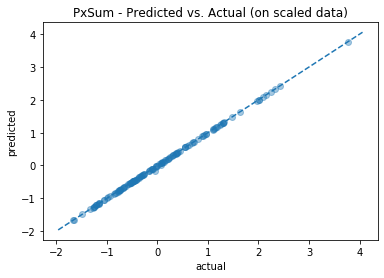

In [224]:
plt.scatter(y_v, yhat_v, alpha=0.4)
xlo, xhi = plt.xlim()
ylo, yhi = plt.ylim()
lo, hi = min(xlo,ylo), max(xhi,yhi)
plt.plot([lo,hi], [lo,hi], linestyle='--');
plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('PxSum - Predicted vs. Actual (on scaled data)');

In [225]:
mse(tensor(yhat_v), tensor(y_v))

tensor(0.0001)

##### Now Attempt on y = `scalar_top`
Much more difficult task, and basic LR is fooled

In [226]:
X, y = df2.iloc[:,:784], df2['scalar_top_sc']

pct_valid = 0.8
np.random.seed(0)
split = [np.random.uniform(0,1,) > pct_valid for _ in range(len(df2))]

X_t, X_v = X.iloc[[not(e) for e in split],:], X.iloc[split,:]
print(X_t.shape, X_v.shape)

y_t, y_v = y.iloc[[not(e) for e in split]], y.iloc[split]
print(y_t.shape, y_v.shape)

(572, 784) (137, 784)
(572,) (137,)


In [227]:
lr.fit(X_t, y_t);

lr.score(X_t, y_t), lr.score(X_v, y_v)

(0.996863034008065, -3203.30103862316)

##### Utilize Ridge Adjustment
This brings us to a decent perf of 0.8 R2

and MSE = 0.164 (better than 0.405 on resnet18-50epoch model)

In [228]:
from sklearn.linear_model import Ridge

lr2 = Ridge(alpha=1e7)

lr2.fit(X_t, y_t);

lr2.score(X_t, y_t), lr2.score(X_v, y_v)

(0.8700236084907995, 0.8091205826214883)

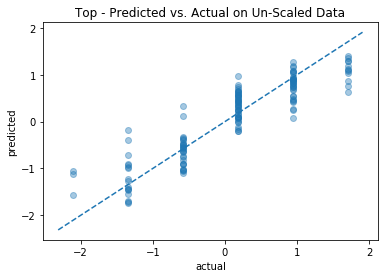

In [229]:
yhat_v = lr2.predict(X_v)

plt.scatter(y_v, yhat_v, alpha=0.4)
xlo, xhi = plt.xlim()
ylo, yhi = plt.ylim()
lo, hi = min(xlo,ylo), max(xhi,yhi)
plt.plot([lo,hi], [lo,hi], linestyle='--');
plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('Top - Predicted vs. Actual on Un-Scaled Data');

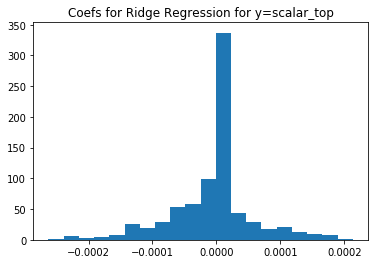

In [230]:
plt.hist(lr2.coef_, bins=20);
plt.title('Coefs for Ridge Regression for y=scalar_top');

In [231]:
mse(tensor(yhat_v), tensor(y_v))

tensor(0.1644)